# mclSTExp Benchmark (INT25-INT28)

## Environment
mclSTExp requires PyTorch >= 2.1.0 (though 2.0 might work) and Scanpy >= 1.8.

```bash
conda create -n mcl_bench python=3.9
conda activate mcl_bench
pip install torch==2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install scanpy pandas numpy opencv-python pillow scikit-image scikit-learn seaborn matplotlib tqdm scprep timm einops
```

In [17]:
import os
import sys
from pathlib import Path

# Set Paths
ROOT = Path(os.environ.get('MORPHO_VC_ROOT', '../')).expanduser().resolve()
MCL_ROOT = ROOT / 'benchmark' / 'mclSTExp'
RESULT_DIR = ROOT / 'benchmark' / 'results' / 'mclSTExp'
DATA_ROOT = RESULT_DIR / 'data'

# sys.path.append(str(MCL_ROOT)) # We will define models inline to be self-contained

RESULT_DIR.mkdir(parents=True, exist_ok=True)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print(f"ROOT: {ROOT}")
print(f"MCL_ROOT: {MCL_ROOT}")
print(f"DATA_ROOT: {DATA_ROOT}")

ROOT: D:\code\Morpho-VC
MCL_ROOT: D:\code\Morpho-VC\benchmark\mclSTExp
DATA_ROOT: D:\code\Morpho-VC\benchmark\results\mclSTExp\data


In [18]:
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json
import shutil
import scprep
from tqdm import tqdm

# Load common genes
spatial_dir = ROOT / 'data' / 'spatial_data'
hest_dir = ROOT / 'data' / 'hest_data'
common_gene_path = spatial_dir / 'common_genes.txt'
with open(common_gene_path, 'r') as f:
    common_genes = [line.strip() for line in f.readlines()]
print(f"Loaded {len(common_genes)} common genes.")

Loaded 17512 common genes.


## 1. Data Conversion (HEST -> mclSTExp)

Convert INT25-INT28 to 10x Visium format required by mclSTExp.

In [19]:
def convert_hest_to_mcl(slide_id):
    print(f"Converting {slide_id}...")
    sample_dir = DATA_ROOT / slide_id
    sample_dir.mkdir(parents=True, exist_ok=True)
    
    # if (sample_dir / 'preprocessed_matrix.npy').exists():
    #     print(f"  {slide_id} already exists.")
    #     return
    
    adata = sc.read_h5ad(spatial_dir / f"{slide_id}.h5ad")
    adata = adata[:, common_genes].copy()
    
    # Preprocessing (Log Norm)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Save Matrix (n_features, n_spots) for mclSTExp .T loading
    processed_matrix = adata.X.toarray().T if hasattr(adata.X, 'toarray') else adata.X.T
    np.save(sample_dir / 'preprocessed_matrix.npy', processed_matrix)
    
    # Barcodes
    barcodes = pd.DataFrame(adata.obs_names)
    barcodes.to_csv(sample_dir / 'barcodes.tsv', sep='\t', header=False, index=False)
    
    # Image
    tiff_path = hest_dir / 'wsis' / f"{slide_id}.tif"
    if not tiff_path.exists(): tiff_path = hest_dir / 'wsis' / f"{slide_id}.svs"
    
    import openslide
    slide = openslide.OpenSlide(str(tiff_path))
    w, h = slide.dimensions
    MAX_SIZE = 4000
    scale = min(MAX_SIZE / w, MAX_SIZE / h)
    level = slide.get_best_level_for_downsample(1/scale)
    img = slide.read_region((0, 0), level, slide.level_dimensions[level]).convert('RGB')
    true_scale_w = img.size[0] / w
    true_scale_h = img.size[1] / h
    img.save(sample_dir / 'image.tif')
    
    # Spatial Positions
    coords = adata.obsm['spatial']
    px_coords = coords.copy().astype(float)
    px_coords[:, 0] *= true_scale_w # x (col)
    px_coords[:, 1] *= true_scale_h # y (row)
    
    pos_df = pd.DataFrame(index=adata.obs_names)
    pos_df['barcode'] = adata.obs_names
    pos_df['in_tissue'] = 1
    pos_df['array_row'] = 0 
    pos_df['array_col'] = 0
    pos_df['px_row'] = px_coords[:, 1].astype(int) # y
    pos_df['px_col'] = px_coords[:, 0].astype(int) # x
    pos_df.to_csv(sample_dir / 'tissue_positions_list.csv', header=False, index=False)
    print(f"  Done {slide_id}")

ids = ['INT25', 'INT26', 'INT27', 'INT28']
for s in ids:
    convert_hest_to_mcl(s)

Converting INT25...
  Done INT25
Converting INT26...
  Done INT26
Converting INT27...
  Done INT27
Converting INT28...
  Done INT28


## 2. Model & Dataset Definitions
Implemented locally to avoid dependency issues.

In [20]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange
from torchvision.models import DenseNet121_Weights
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import random
from torch.utils.data import DataLoader, Dataset

# --- MODEL DEFINITIONS ---
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads 
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class attn_block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.attn = PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout))
        self.ff = PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
    def forward(self, x):
        x = self.attn(x) + x
        x = self.ff(x) + x
        return x

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        for p in self.model.parameters():
            p.requires_grad = True
    def forward(self, x):
        x = self.model(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        return x

class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim, dropout=0.):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class mclSTExp_Attention(nn.Module):
    def __init__(self, encoder_name, temperature, image_dim, spot_dim, projection_dim, heads_num, heads_dim, head_layers, dropout=0.):
        super().__init__()
        self.x_embed = nn.Embedding(65536, spot_dim)
        self.y_embed = nn.Embedding(65536, spot_dim)
        self.image_encoder = ImageEncoder()
        self.spot_encoder = nn.Sequential(
            *[attn_block(spot_dim, heads=heads_num, dim_head=heads_dim, mlp_dim=spot_dim, dropout=0.) for _ in range(head_layers)]
        )
        self.image_projection = ProjectionHead(embedding_dim=image_dim, projection_dim=projection_dim)
        self.spot_projection = ProjectionHead(embedding_dim=spot_dim, projection_dim=projection_dim)
        self.temperature = temperature
    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        spot_feature = batch["expression"]
        image_embeddings = self.image_projection(image_features)
        x = batch["position"][:, 0].long()
        y = batch["position"][:, 1].long()
        centers_x = self.x_embed(x)
        centers_y = self.y_embed(y)
        spot_features = spot_feature + centers_x + centers_y
        spot_features = spot_features.unsqueeze(dim=0)
        spot_embeddings = self.spot_encoder(spot_features)
        spot_embeddings = self.spot_projection(spot_embeddings)
        spot_embeddings = spot_embeddings.squeeze(dim=0)
        cos_smi = (spot_embeddings @ image_embeddings.T) / self.temperature
        label = torch.eye(cos_smi.shape[0], cos_smi.shape[1]).to(cos_smi.device)
        spots_loss = F.cross_entropy(cos_smi, label)
        images_loss = F.cross_entropy(cos_smi.T, label.T)
        loss = (images_loss + spots_loss) / 2.0
        return loss.mean()

# --- DATASET ---

class CustomTenxDataset(Dataset):
    def __init__(self, slide_id, data_root, train=True, gene_indices=None):
        self.slide_id = slide_id
        self.data_dir = data_root / slide_id
        self.whole_image = cv2.imread(str(self.data_dir / 'image.tif'))
        self.whole_image = cv2.cvtColor(self.whole_image, cv2.COLOR_BGR2RGB)
        self.pos_df = pd.read_csv(self.data_dir / 'tissue_positions_list.csv', header=None)
        self.barcodes = pd.read_csv(self.data_dir / 'barcodes.tsv', sep='\t', header=None)
        
        # Load full matrix (Spots, Genes)
        full_expression = np.load(self.data_dir / 'preprocessed_matrix.npy').T
        
        if gene_indices is not None:
            self.expression = full_expression[:, gene_indices]
        else:
            self.expression = full_expression
            
        self.train = train
    
    def transform(self, image):
        image = Image.fromarray(image)
        if self.train:
            if random.random() > 0.5:
                image = TF.hflip(image)
            if random.random() > 0.5:
                image = TF.vflip(image)
            angle = random.choice([180, 90, 0, -90])
            image = TF.rotate(image, angle)
        return np.asarray(image)

    def __len__(self):
        return len(self.barcodes)

    def __getitem__(self, idx):
        item = {}
        row = self.pos_df.iloc[idx]
        v1 = int(row[4]) 
        v2 = int(row[5]) 
        r = 112
        img_h, img_w, _ = self.whole_image.shape
        y_min = max(0, v1 - r)
        y_max = min(img_h, v1 + r)
        x_min = max(0, v2 - r)
        x_max = min(img_w, v2 + r)
        patch = self.whole_image[y_min:y_max, x_min:x_max]
        if patch.shape[0] < 224 or patch.shape[1] < 224:
            patch = np.pad(patch, ((0, 224 - patch.shape[0]), (0, 224 - patch.shape[1]), (0, 0)), mode='constant')
        patch = self.transform(patch)
        item['image'] = torch.tensor(patch).permute(2, 0, 1).float() / 255.0
        item['expression'] = torch.tensor(self.expression[idx, :]).float()
        item['barcode'] = self.barcodes.values[idx, 0]
        item['position'] = torch.tensor([v1, v2]).float()
        return item


## 3. Training & Prediction Loop

In [21]:
from tqdm import tqdm

def train_mcl_chunk(train_slides, val_slides, gene_indices, epochs=50, batch_size=32, device='cuda', patience=5, min_delta=0.001):
    # Train Data
    datasets = [CustomTenxDataset(s, DATA_ROOT, train=True, gene_indices=gene_indices) for s in train_slides]
    train_ds = torch.utils.data.ConcatDataset(datasets)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    # Validation Data (INT27) - train=False 用于关闭数据增强
    val_datasets = [CustomTenxDataset(s, DATA_ROOT, train=False, gene_indices=gene_indices) for s in val_slides]
    val_ds = torch.utils.data.ConcatDataset(val_datasets)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    n_genes = len(gene_indices)
    
    model = mclSTExp_Attention(
        encoder_name='densenet121', temperature=0.1, 
        image_dim=1024, spot_dim=n_genes, projection_dim=256,
        heads_num=8, heads_dim=64, head_layers=2
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # 早停变量
    best_val_loss = float('inf')
    patience_counter = 0
    
    # print(f"  Start training for {epochs} epochs (Patience: {patience})...")
    
    for epoch in range(epochs):
        # --- Training ---
        model.train()
        train_loss = 0
        pbar = tqdm(train_loader, desc=f"    Epoch {epoch+1}/{epochs} [Train]", leave=False, ncols=100)
        
        for batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items() if k in ['image', 'expression', 'position']}
            optimizer.zero_grad()
            loss = model(batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_postfix({'t_loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        
        # --- Validation ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items() if k in ['image', 'expression', 'position']}
                loss = model(batch)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        # 打印 (只在 Epoch 1, 10, 20... 或早停时打印)
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

        # === Val Loss Early Stopping ===
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"    [Early Stopping] Stopped at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break
            
    return model

def predict_mcl_chunk(model, train_slides, target_slide, gene_indices, device='cuda', top_k=50):
    model.eval()
    
    # Target Embeddings
    target_ds = CustomTenxDataset(target_slide, DATA_ROOT, train=False, gene_indices=gene_indices)
    target_loader = DataLoader(target_ds, batch_size=64, shuffle=False)
    
    target_img_embs = []
    with torch.no_grad():
        for batch in target_loader:
            imgs = batch['image'].to(device)
            feats = model.image_encoder(imgs)
            embs = model.image_projection(feats)
            target_img_embs.append(embs.cpu())
    target_img_embs = torch.cat(target_img_embs, dim=0)

    # Key Embeddings
    train_datasets = [CustomTenxDataset(s, DATA_ROOT, train=False, gene_indices=gene_indices) for s in train_slides]
    train_ds = torch.utils.data.ConcatDataset(train_datasets)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
    
    key_spot_embs = []
    key_expressions = []
    
    with torch.no_grad():
        for batch in train_loader:
            exp = batch['expression'].to(device)
            pos = batch['position'].to(device)
            c_x = model.x_embed(pos[:, 0].long())
            c_y = model.y_embed(pos[:, 1].long())
            spot_feat = exp + c_x + c_y
            enc_feat = model.spot_encoder(spot_feat.unsqueeze(0))
            proj_feat = model.spot_projection(enc_feat).squeeze(0)
            key_spot_embs.append(proj_feat.cpu())
            key_expressions.append(exp.cpu())
            
    key_spot_embs = torch.cat(key_spot_embs, dim=0)
    key_expressions = torch.cat(key_expressions, dim=0)
    
    # Matching
    Q = F.normalize(target_img_embs.to(device), p=2, dim=1)
    K = F.normalize(key_spot_embs.to(device), p=2, dim=1)
    V = key_expressions.to(device)
    
    final_preds = []
    chunk_size = 500
    for i in range(0, len(Q), chunk_size):
        q_chunk = Q[i:i+chunk_size]
        sim = q_chunk @ K.T
        sim = torch.clamp(sim, -1.0, 0.9999)
        dist_sq = 2 * (1 - sim)
        weights = (1.0 / dist_sq)
        
        top_w, top_idx = torch.topk(weights, k=top_k, dim=1)
        vals = V[top_idx]
        norm_w = top_w / top_w.sum(dim=1, keepdim=True)
        chunk_pred = (vals * norm_w.unsqueeze(2)).sum(dim=1)
        final_preds.append(chunk_pred.cpu())
        
    return torch.cat(final_preds, dim=0).numpy()

In [22]:
import gc
import json

train_slides = ['INT25', 'INT26']
val_slides = ['INT27']   # 新增验证集
target_slide = 'INT28'

# Need to know total genes first. Read one dataset headers
temp_ds = CustomTenxDataset('INT25', DATA_ROOT)
# 修正：直接读取 shape，避免加载整个矩阵
total_genes = temp_ds.expression.shape[1]
print(f"Total Genes: {total_genes}")
del temp_ds

chunk_size = 3000
all_preds = []
all_indices = []

# Ground Truth load ONCE
print("Loading Ground Truth Data...")
target_ds_full = CustomTenxDataset(target_slide, DATA_ROOT, train=False)
ground_truth = target_ds_full.expression # Full genes
barcodes_gt = target_ds_full.barcodes
print("Ground Truth Loaded.")

# 修正循环逻辑
for start_idx in range(0, total_genes, chunk_size):
    end_idx = min(start_idx + chunk_size, total_genes)
    indices = np.arange(start_idx, end_idx)
    result_path = RESULT_DIR / f"preds_chunk_{start_idx}_{end_idx}.npy"

    print(f"\n=== Processing Chunk {start_idx}-{end_idx} ({len(indices)} genes) ===")

    if result_path.exists():
        print(f"  [Cache] Found existing result: {result_path}")
        print("  Loading from cache...")
        preds = np.load(result_path)
    else:
        print("  [Train] No cache found. Starting training chunk model...")
        # Train (Pass val_slides now)
        model = train_mcl_chunk(train_slides, val_slides, indices, epochs=50, batch_size=32)

        print("  [Predict] Predicting target slide...")
        # Predict
        preds = predict_mcl_chunk(model, train_slides, target_slide, indices)
        np.save(result_path, preds)
        print(f"  [Save] Saved chunk result to {result_path}")

        # Cleanup
        del model
        gc.collect()
        torch.cuda.empty_cache()
        print("  [Clean] Memory cleared.")

    all_preds.append(preds)
    all_indices.append(indices)

print("\nAll chunks processed. Concatenating results...")
# Concatenate
full_preds = np.concatenate(all_preds, axis=1) # (N_spots, N_genes)

# Metrics
print(f"Pred Shape: {full_preds.shape}, GT Shape: {ground_truth.shape}")
mae = np.mean(np.abs(full_preds - ground_truth))
rmse = np.sqrt(np.mean((full_preds - ground_truth) ** 2))

def pearson_corr(a, b):
    # 避免常数数组导致的除零错误
    if np.all(a == a[0]) or np.all(b == b[0]): return np.nan
    a, b = a - a.mean(), b - b.mean()
    denom = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())
    return (a*b).sum() / denom if denom != 0 else np.nan

print("Calculating Pearson Correlation...")
pccs = [pearson_corr(full_preds[:, i], ground_truth[:, i]) for i in tqdm(range(full_preds.shape[1]), desc="Calc PCC")]
mean_pcc = np.nanmean(pccs)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Pearson: {mean_pcc:.4f}")

metrics = {'MAE': float(mae), 'RMSE': float(rmse), 'Mean_Pearson': float(mean_pcc)}
with open(RESULT_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Metrics saved to {RESULT_DIR / 'metrics.json'}")

Total Genes: 17512
Loading Ground Truth Data...
Ground Truth Loaded.

=== Processing Chunk 0-3000 (3000 genes) ===
  [Cache] Found existing result: D:\code\Morpho-VC\benchmark\results\mclSTExp\preds_chunk_0_3000.npy
  Loading from cache...

=== Processing Chunk 3000-6000 (3000 genes) ===
  [Cache] Found existing result: D:\code\Morpho-VC\benchmark\results\mclSTExp\preds_chunk_3000_6000.npy
  Loading from cache...

=== Processing Chunk 6000-9000 (3000 genes) ===
  [Cache] Found existing result: D:\code\Morpho-VC\benchmark\results\mclSTExp\preds_chunk_6000_9000.npy
  Loading from cache...

=== Processing Chunk 9000-12000 (3000 genes) ===
  [Cache] Found existing result: D:\code\Morpho-VC\benchmark\results\mclSTExp\preds_chunk_9000_12000.npy
  Loading from cache...

=== Processing Chunk 12000-15000 (3000 genes) ===
  [Cache] Found existing result: D:\code\Morpho-VC\benchmark\results\mclSTExp\preds_chunk_12000_15000.npy
  Loading from cache...

=== Processing Chunk 15000-17512 (2512 genes)

Calc PCC: 100%|██████████| 17512/17512 [00:02<00:00, 7774.03it/s]

MAE: 0.2065
RMSE: 0.3756
Mean Pearson: 0.0555
Metrics saved to D:\code\Morpho-VC\benchmark\results\mclSTExp\metrics.json


In [26]:
# 修改这里：使用上一个Cell已经计算好的 full_preds 和 ground_truth
preds = full_preds
truths = ground_truth

# ---- 兼容 torch / numpy ----
if not isinstance(preds, np.ndarray):
    try:
        preds = preds.detach().cpu().numpy()
    except Exception:
        preds = np.array(preds)

if not isinstance(truths, np.ndarray):
    try:
        truths = truths.detach().cpu().numpy()
    except Exception:
        truths = np.array(truths)

# 下面的代码保持不变
# Metrics
mae = np.mean(np.abs(preds - truths))
rmse = np.sqrt(np.mean((preds - truths) ** 2))

def pearson_corr(a, b):
    # 这个函数用于 overall mean_pcc（保持你原本的 nan 逻辑）
    if np.all(a == a[0]) or np.all(b == b[0]): 
        return np.nan
    a, b = a - a.mean(), b - b.mean()
    denom = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())
    return (a*b).sum() / denom if denom != 0 else np.nan

pccs = [pearson_corr(preds[:, i], truths[:, i]) for i in range(preds.shape[1])]
mean_pcc = np.nanmean(pccs)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Pearson: {mean_pcc:.4f}")

# ===================== Top-4 genes (与可视化脚本一致：std==0 -> corr=0) =====================
G = preds.shape[1]

# 1) 基因名：优先 common_genes（与你绘图那段一致）
if "common_genes" in locals():
    gnames = np.asarray(common_genes)
elif "gene_names" in locals():
    gnames = np.asarray(gene_names)
else:
    gnames = np.array([f"Gene_{i}" for i in range(G)], dtype=str)

# bytes -> str
gnames = np.array(
    [(x.decode() if isinstance(x, (bytes, bytearray)) else str(x)) for x in gnames],
    dtype=str
)

# 长度不匹配时兜底
if len(gnames) != G:
    gnames = np.array([f"Gene_{i}" for i in range(G)], dtype=str)

# 2) per-gene MAE/RMSE（用于 tie-break）
gene_mae  = np.mean(np.abs(preds - truths), axis=0)
gene_rmse = np.sqrt(np.mean((preds - truths) ** 2, axis=0))

# 3) per-gene corr（用于 Top4 排序；严格按你绘图逻辑）
gene_corr = np.zeros(G, dtype=float)
for i in range(G):
    tr = truths[:, i]
    pr = preds[:, i]
    if np.std(tr) == 0 or np.std(pr) == 0:
        c = 0.0
    else:
        c = np.corrcoef(tr, pr)[0, 1]
        if not np.isfinite(c):
            c = 0.0
    gene_corr[i] = c

# 4) 排序：corr 降序；RMSE 升序；MAE 升序
order = np.lexsort((gene_mae, gene_rmse, -gene_corr))  # 最后一个 key 是主排序
top4_idx = order[:4].tolist()
top4_genes = gnames[top4_idx].tolist()
top4_corrs = gene_corr[top4_idx].tolist()

print("\nTop-4 genes by Pearson (desc):")
for k, (gi, gn, cc) in enumerate(zip(top4_idx, top4_genes, top4_corrs), start=1):
    print(f"  {k}. {gn} (idx={gi}): Corr={cc:.4f}, RMSE={gene_rmse[gi]:.4f}, MAE={gene_mae[gi]:.4f}")

# # ===================== 保存 metrics.json（包含 top4 信息，方便你后续画图直接用） =====================
# metrics = {
#     "MAE": float(mae),
#     "RMSE": float(rmse),
#     "Mean_Pearson": float(mean_pcc),
#     "Top4_Genes": top4_genes,
#     "Top4_Gene_Idx": [int(x) for x in top4_idx],
#     "Top4_Gene_Pearson": [float(x) for x in top4_corrs],
# }
# with open(RESULT_DIR / "metrics.json", "w") as f:
#     json.dump(metrics, f, indent=4)


MAE: 0.2065
RMSE: 0.3756
Mean Pearson: 0.0555

Top-4 genes by Pearson (desc):
  1. TPM2 (idx=15563): Corr=0.5537, RMSE=1.1200, MAE=0.9031
  2. KLK2 (idx=7512): Corr=0.5446, RMSE=0.5681, MAE=0.5047
  3. ACTA2 (idx=195): Corr=0.5186, RMSE=1.0023, MAE=0.8103
  4. AZGP1 (idx=1267): Corr=0.4560, RMSE=1.1844, MAE=0.9550


Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Coords Range: X[2884.0, 12363.0], Y[1596.0, 11424.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
Using pixel-space extent (0..W, H..0) for alignment.
Using 'ground_truth' as Ground Truth Matrix T
Calculating Pearson correlations...


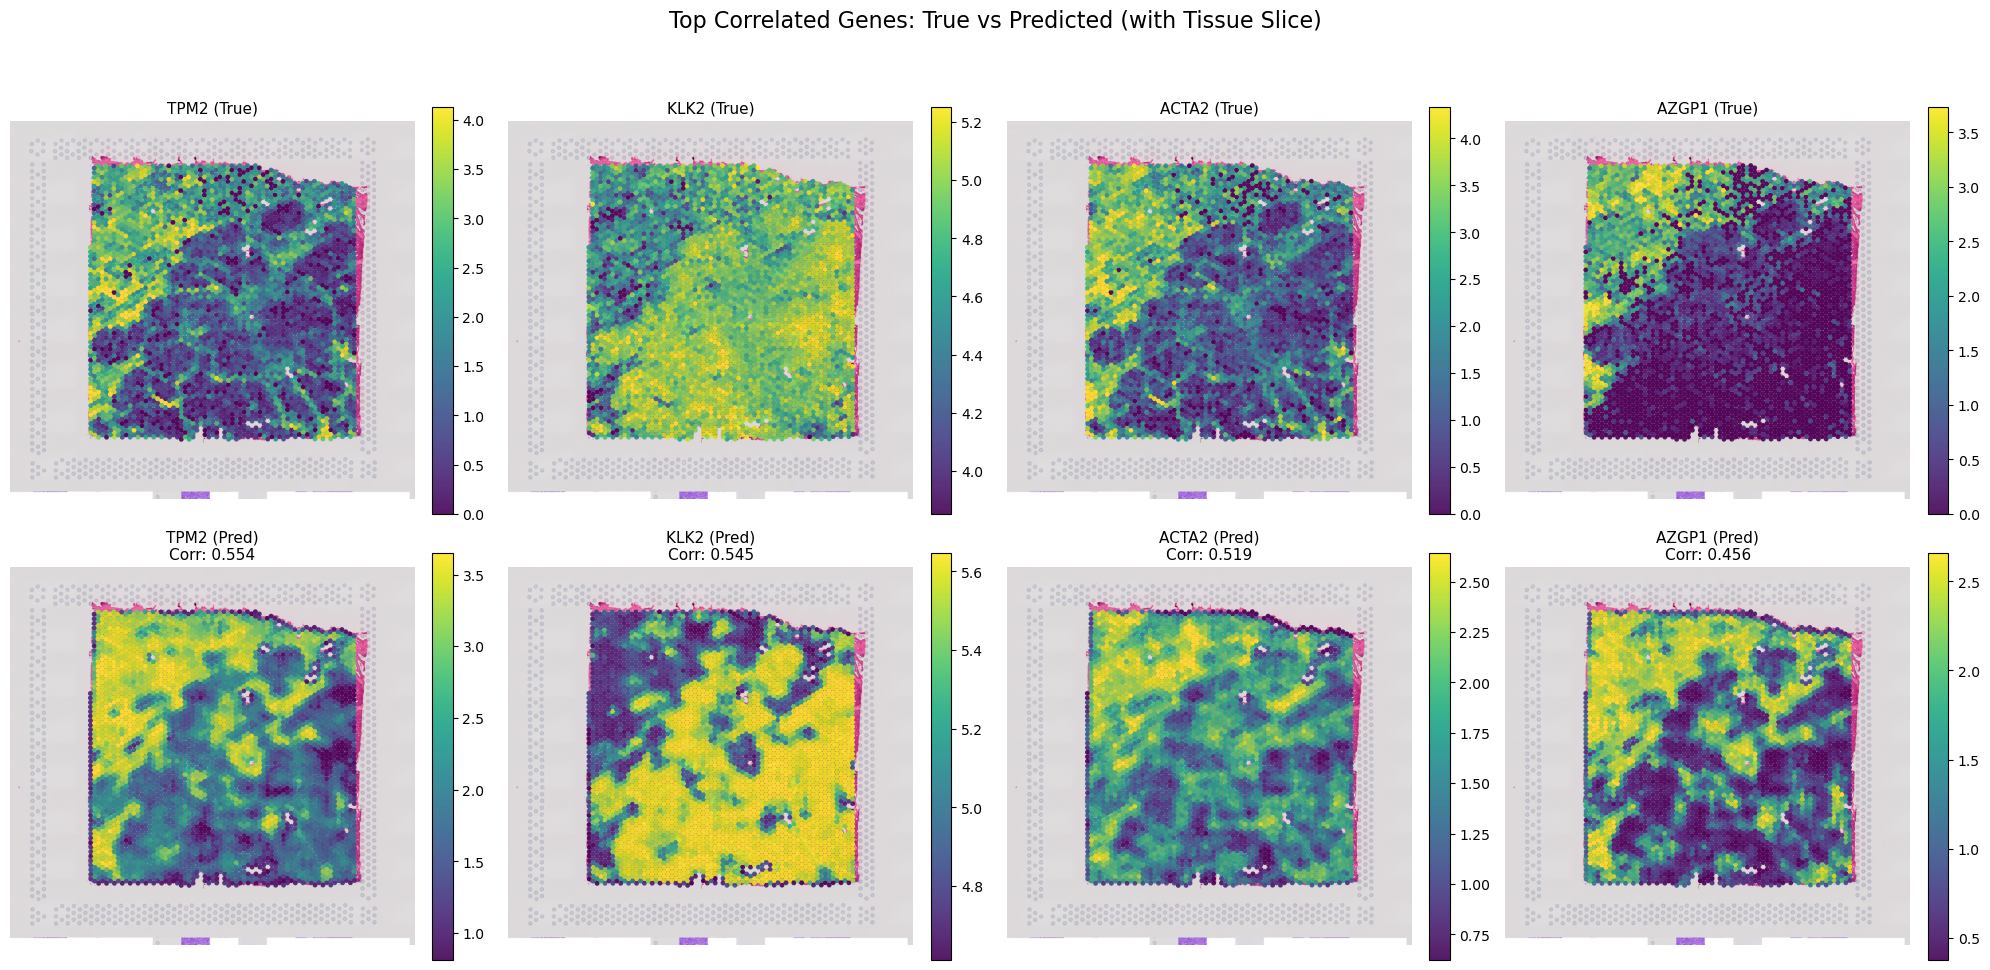

In [24]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
try:
    from PIL import Image
except ImportError:
    Image = None

def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from *this panel's* values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax

# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = "INT28"

ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()
DATA_DIR = ROOT / "data" / "spatial_data"
HEST_DIR = ROOT / "data" / "hest_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback (keep your style)
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords
# ----------------------------
try:
    adata = sc.read_h5ad(h5ad_path)
    coords = adata.obsm["spatial"]  # shape (N, 2)
    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # Fallback to defaults
    n_points = 100
    # Attempt to sniff shape from locals if available
    if 'P' in locals(): n_points = P.shape[0]
    elif 'preds' in locals(): n_points = preds.shape[0]
    
    x, y = np.random.rand(n_points), np.random.rand(n_points)
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None

wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
if len(wsi_files) > 0:
    wsi_path = wsi_files[0]
    print(f"Found WSI: {wsi_path}")

    try:
        import openslide  # noqa: F401
        slide = openslide.OpenSlide(str(wsi_path))
        w0, h0 = slide.dimensions
        thumb_w = 2000
        scale = thumb_w / w0
        thumb_h = int(h0 * scale)
        bg_img = slide.get_thumbnail((thumb_w, thumb_h))
        in_pixel_space = (
            (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
            (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
        )
        if in_pixel_space:
            bg_extent = (0, w0, h0, 0)
            print("Using pixel-space extent (0..W, H..0) for alignment.")
        else:
            bg_extent = (min_x, max_x, max_y, min_y)
            print("Coords not in pixel space; stretching background to coords bounding box.")
    except Exception as e:
        print(f"OpenSlide failed ({e}), trying PIL...")
        try:
            if hasattr(Image, 'MAX_IMAGE_PIXELS'):
                Image.MAX_IMAGE_PIXELS = None
            img = Image.open(wsi_path)
            w0, h0 = img.size
            img.thumbnail((2000, 2000))
            bg_img = img
            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )
            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")
        except Exception as e2:
            print(f"[WARNING] PIL background load failed: {e2}")
            bg_img, bg_extent = None, None
else:
    print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))

# ----------------------------
# 3) Pick Top-4 genes by correlation (Recalculate)
# ----------------------------
try:
    # Standardize names
    if 'P' not in locals() and 'preds' in locals(): 
        print("Using 'preds' as Prediction Matrix P")
        P = preds
    
    if 'T' not in locals():
        if 'targets' in locals():
             print("Using 'targets' as Ground Truth Matrix T")
             T = targets
        elif 'ground_truth' in locals():
             print("Using 'ground_truth' as Ground Truth Matrix T")
             T = ground_truth
        elif 'truths' in locals():
             print("Using 'truths' as Ground Truth Matrix T")
             T = truths

    if 'P' in locals() and 'T' in locals():
        print("Calculating Pearson correlations...")
        valid = []
        # Assuming shape (N_spots, N_genes)
        # Convert to numpy if needed
        if not isinstance(T, np.ndarray):
            try: T = T.cpu().detach().numpy()
            except: T = np.array(T)
        if not isinstance(P, np.ndarray):
            try: P = P.cpu().detach().numpy()
            except: P = np.array(P)

        for i in range(T.shape[1]):
            # Compute corr for gene i
            # Handle potential constant/nan
            tr = T[:, i]
            pr = P[:, i]
            if np.std(tr) == 0 or np.std(pr) == 0:
                 c = 0
            else:
                 c = np.corrcoef(tr, pr)[0, 1]
            
            if np.isfinite(c):
                valid.append((i, c))
        
        sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
        top4_genes = sorted_genes[:4]
        n_show = len(top4_genes)
    else:
        print("CRITICAL: Matrices 'P' and 'T' (or equiv) not found.")
        print(f"Locals: {list(locals().keys())}")
        n_show = 0

except Exception as e:
    print(f"Error computing correlations: {e}")
    n_show = 0

# ----------------------------
# 4) Plot (2 rows: True vs Pred)
# ----------------------------
if n_show > 0:
    fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
    if n_show == 1:
        axes = np.array(axes).reshape(2, 1)

    fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

    for i, (gene_idx, corr) in enumerate(top4_genes):
        if 'common_genes' in locals() and gene_idx < len(common_genes):
            gene_name = common_genes[gene_idx]
        else:
            gene_name = f"Gene_{gene_idx}"

        gt_expr = T[:, gene_idx]
        pr_expr = P[:, gene_idx]

        # Panel-wise dynamic range
        vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
        vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

        # --- Row 1: Ground Truth ---
        ax_gt = axes[0, i]
        if bg_img is not None and bg_extent is not None:
            ax_gt.imshow(bg_img, extent=bg_extent)
        sc_gt = ax_gt.scatter(
            x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
            vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
        )
        ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
        ax_gt.axis("off")
        if bg_img is None:
            ax_gt.invert_yaxis()
        plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

        # --- Row 2: Prediction ---
        ax_pr = axes[1, i]
        if bg_img is not None and bg_extent is not None:
            ax_pr.imshow(bg_img, extent=bg_extent)
        sc_pr = ax_pr.scatter(
            x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
            vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
        )
        ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
        ax_pr.axis("off")
        if bg_img is None:
            ax_pr.invert_yaxis()
        plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
